##Descargar repo de Mask_RCNN e intalar los requerimientos

Descargar repo

In [1]:
%cd
  

!git clone --quiet https://github.com/matterport/Mask_RCNN.git

/root


Instalar requisitos

In [2]:
%cd ~/Mask_RCNN

!pip install -q PyDrive
!pip install -r requirements.txt
!python setup.py install

/root/Mask_RCNN
    100% |████████████████████████████████| 993kB 20.3MB/s 
    100% |████████████████████████████████| 204kB 27.2MB/s 
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/b

## Importar módulos y leer imágenes con anotaciones

Se descargan los módulos necesarios, y el modelo preentrenado COCO (se probó coco e imagenet, coco obtiene mejores resultados)

In [3]:
%cd ~/Mask_RCNN/samples/shapes

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import skimage.draw

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/root/Mask_RCNN/samples/shapes


Using TensorFlow backend.


... done downloading pretrained model!


Se edita e inicializa la clase ThingsConfig, que posee parámetros para el módelo.

Aquí se debe editar NUM_CLASES según cuantas clases se quieran identificar. Siempre es n+1, ya que se toma en cuenta el fondo como clase individual.

In [4]:
%cd ~/Mask_RCNN/samples/shapes

class ThingsConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "things"

    
    # Increase the amount of images only if the images dimentions are small
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 2 objects
    

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
        # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    

    
config = ThingsConfig()
config.display()

/root/Mask_RCNN/samples/shapes

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE        

Genera un array para visualizar las imagenes de prueba con las masks.

In [5]:
%cd ~/Mask_RCNN/samples/shapes

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
  
    Change the default size attribute to control the size
    of rendered images
    
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

/root/Mask_RCNN/samples/shapes


La siguiente clase es la que lee las anotaciones y las entrega al modelo para entrenar o validar.

Las secciones a editar son:
 - Añadir/quitar clases donde indicado en el formato:
 

```
self.add_class("things", numero_identificador, nombre_clase)
```
-  Añadir la relación entre el nombre de la clase y el número identificador, dentro del for marcado dentro del código



In [6]:
%cd ~/Mask_RCNN/samples/shapes
class ThingsDataset(utils.Dataset):

    def load_things(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("things", 1, "traffic sign")
        self.add_class("things", 2, "drivable area")
        self.add_class("things", 3, "car")
        self.add_class("things", 4, "bike")

        classnumbers = {"traffic sign": 1, "drivable area": 2, "car": 3, "bike": 4}
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
                objects = [s['region_attributes'] for s in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
                objects = [s['region_attributes'] for s in a['regions']]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.

            num_ids = [classnumbers[n['name']] for n in objects]

            
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "things",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        info = self.image_info[image_id]
        if info["source"] != "things":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]

        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            
            rr[rr > mask.shape[0]-1] = mask.shape[0]-1
            cc[cc > mask.shape[1]-1] = mask.shape[1]-1
            
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "things":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

/root/Mask_RCNN/samples/shapes


## Descargar dataset y procesar

Descargar dataset si se está usando colab. Se comprime un zip con una carpeta que contiene a train y valid con la siguiente estructura:
```
images.zip
"images" directory
    |- "train" directory
      |- jpg image files of training data
      |- "via_region_data.json" annotations file of training data
    |- "val" directory
      |- jpg image files of validation data
      |- "via_region_data.json" annotations file of validation data
```

Se busca el id del archivo.zip una vez subido a drive (viene al crear un link para compartir), y se reemplaza en fileId abajo. Luego se confirman los permisos necesarios.

In [7]:
%cd ~/Mask_RCNN


fileId = '1QeOrwKcb7IFCCxtGYOjKxPV4nnsrOc4O'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

os.makedirs('dataset')
os.chdir('dataset')

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

/root/Mask_RCNN
Extracted zip file 1QeOrwKcb7IFCCxtGYOjKxPV4nnsrOc4O.zip


Marcar el directorio del dataset, cambiar "testingdb" por el nombre de la carpeta que contiene train y valid

In [8]:
%cd ~/Mask_RCNN/dataset/Multicat
! ls
THINGS_DIR = os.path.join(ROOT_DIR, "dataset/Multicat")

/root/Mask_RCNN/dataset/Multicat
train  val


Proceso el dataset de entrenamiento y validación

In [9]:
%cd ~/Mask_RCNN/samples/shapes

# Training dataset
dataset_train = ThingsDataset()
dataset_train.load_things(THINGS_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = ThingsDataset()
dataset_val.load_things(THINGS_DIR, "val")
dataset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_train.image_ids), dataset_train.class_names))
print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

/root/Mask_RCNN/samples/shapes
Images: 9999
Classes: ['BG', 'traffic sign', 'drivable area', 'car', 'bike']
Images: 10
Classes: ['BG', 'traffic sign', 'drivable area', 'car', 'bike']


Muestra algunos ejemplos de masks a partir del entrenamiento

/root/Mask_RCNN/samples/shapes


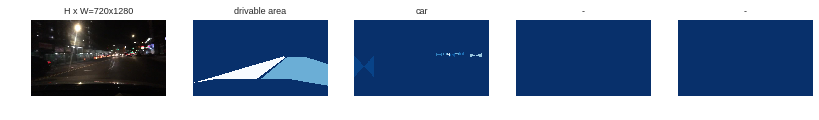

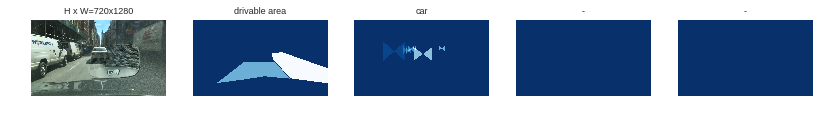

In [10]:
%cd ~/Mask_RCNN/samples/shapes

# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 2)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Crear modelo y entrenar

Crea el modelo y le da los parámetros iniciales

In [11]:
%cd ~/Mask_RCNN/samples/shapes
print(config)
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

/root/Mask_RCNN/samples/shapes
Instructions for updating:
Colocations handled automatically by placer.


In [12]:
%cd ~/Mask_RCNN/samples/shapes
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

/root/Mask_RCNN/samples/shapes


Entrenamiento inicial, con las capas "superficiales"

In [13]:
%cd ~/Mask_RCNN/samples/shapes
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')

/root/Mask_RCNN/samples/shapes

Starting at epoch 0. LR=0.001

Checkpoint Path: /root/Mask_RCNN/logs/things20190210T0023/mask_rcnn_things_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Ti

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
100/100 [==============================] - 199s 2s/step - loss: 2.1545 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 0.4960 - mrcnn_class_loss: 0.4571 - mrcnn_bbox_loss: 0.5342 - mrcnn_mask_loss: 0.6030 - val_loss: 1.8473 - val_rpn_class_loss: 0.0339 - val_rpn_bbox_loss: 0.2755 - val_mrcnn_class_loss: 0.2123 - val_mrcnn_bbox_loss: 0.5495 - val_mrcnn_mask_loss: 0.7761
Epoch 2/5
100/100 [==============================] - 132s 1s/step - loss: 1.7861 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 0.4886 - mrcnn_class_loss: 0.3449 - mrcnn_bbox_loss: 0.4327 - mrcnn_mask_loss: 0.4656 - val_loss: 1.7274 - val_rpn_class_loss: 0.0331 - val_rpn_bbox_loss: 0.3127 - val_mrcnn_class_loss: 0.1716 - val_mrcnn_bbox_loss: 0.3056 - val_mrcnn_mask_loss: 0.9044
Epoch 3/5
100/100 [==============================] - 132s 1s/step - loss: 1.5006 - rpn_class_loss: 0.0450 - rpn_bbox_loss: 0.3875 - mrcnn_class_loss: 0.2836 - mrcnn_bbox_loss: 0.3573 - mrcnn_mask_loss: 0.4273 - val_loss: 1.8115 - val_rpn_class_loss

***OPCIONAL***: Entrenamiento en todas las capas. No es 100% necesario, provoca mejoras en algunas imágenes, pero puede provocar peoras en otras. Idealmente correr una vez el programa sin esta celda y una vez con esta celda, y analizar cual entrega resultados más apropiados para la ocasión.

In [0]:
 %cd ~/Mask_RCNN/samples/shapes
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.

#Uncomment this part to run this optional training:
#model.train(dataset_train, dataset_val, 
            #learning_rate=config.LEARNING_RATE / 10,
            #epochs=1, 
            #layers="all")

/root/Mask_RCNN/samples/shapes

Starting at epoch 5. LR=0.0001

Checkpoint Path: /root/Mask_RCNN/logs/things20190127T1928/mask_rcnn_things_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b  

KeyboardInterrupt: ignored

## Comprobar resultados

Configuraciones para testear el modelo

In [14]:
%cd ~/Mask_RCNN/samples/shapes
class InferenceConfig(ThingsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
weights = model.load_weights(model_path, by_name=True)

/root/Mask_RCNN/samples/shapes

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE        

Procesar las imágenes de la carpeta validation:

In [15]:
#image_id = random.choice(dataset.image_ids)
for image_id in dataset_val.image_ids:
  image, image_meta, gt_class_id, gt_bbox, gt_mask =\
      modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
  info = dataset_val.image_info[image_id]
  print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                         dataset_val.image_reference(image_id)))

  # Run object detection
  results = model.detect([image], verbose=1)

  # Display results
  ax = get_ax(1)
  r = results[0]
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              dataset_val.class_names, r['scores'], ax=ax,
                              title="Predictions")
  log("gt_class_id", gt_class_id)
  log("gt_bbox", gt_bbox)
  log("gt_mask", gt_mask)

Output hidden; open in https://colab.research.google.com to view.